# Exploratory Data Analyis

1. Remove non-countries
2. Remove unnecessary columns - explanation in markdown
3. Extrapolate/Interpolate NaN values based on selected algorithm - select a reasonable time period with acceptable amount of NaN values
4. Look from continent point-of-view
5. Look from country point-of-view (within each continent) and as a whole

##### Import libraries

In [33]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
df = pd.read_csv('owid-energy-data.csv')
df.head()

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
0,Afghanistan,1900,AFG,4832414.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1901,AFG,4879685.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1902,AFG,4935122.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1903,AFG,4998861.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1904,AFG,5063419.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21890 entries, 0 to 21889
Columns: 129 entries, country to wind_share_energy
dtypes: float64(126), int64(1), object(2)
memory usage: 21.5+ MB


In [36]:
cols = pd.read_excel('energy_data.xlsx', sheet_name = 'owid-energy-codebook')
cols = cols['columns']

#### Filter out columns that are not 'per capita' for analysis
Rationale: Absolute energy consumption differs based on geographical sizes and population size, we want to compare 'percentage' changes

In [37]:
# hardcoded the index to remove -> refer to excel where it represents the start of the red-highlighted rows
removed_cols = cols[80:]

In [38]:
df1 = df.drop(columns = removed_cols)
df1.columns

Index(['country', 'year', 'iso_code', 'population', 'gdp',
       'biofuel_cons_change_pct', 'biofuel_cons_per_capita',
       'biofuel_elec_per_capita', 'biofuel_share_elec', 'biofuel_share_energy',
       'coal_cons_change_pct', 'coal_cons_per_capita', 'coal_elec_per_capita',
       'coal_prod_change_pct', 'coal_prod_per_capita', 'coal_share_elec',
       'coal_share_energy', 'electricity_share_energy',
       'energy_cons_change_pct', 'energy_cons_change_twh', 'energy_per_capita',
       'energy_per_gdp', 'fossil_cons_change_pct', 'fossil_elec_per_capita',
       'fossil_energy_per_capita', 'fossil_share_elec', 'fossil_share_energy',
       'gas_cons_change_pct', 'gas_elec_per_capita', 'gas_energy_per_capita',
       'gas_prod_change_pct', 'gas_prod_per_capita', 'gas_share_elec',
       'gas_share_energy', 'greenhouse_gas_emissions', 'hydro_cons_change_pct',
       'hydro_elec_per_capita', 'hydro_energy_per_capita', 'hydro_share_elec',
       'hydro_share_energy', 'low_carbon_cons_c

In [39]:
# for year 2021, this is the number of NaN values across the filtered columns
df1[df1['year'] == 2021].isna().sum().sum()

8847

In [40]:
# initialise new dataframe to store NaN counts
nan_count = pd.DataFrame(columns=['year', 'nan_counts'])

In [41]:
# for each year in the dataset, tally the number of NaN values to determine which year to cut off onwards
# takes quite a while to append (around 35s)
for year in df1['year']:
    count = df1[df1['year'] == year].isna().sum().sum()
    row = [year, count]
    row_df = pd.DataFrame([row], columns = nan_count.columns)
    nan_count = pd.concat([nan_count, row_df], ignore_index=True)


<Axes: xlabel='year', ylabel='nan_counts'>

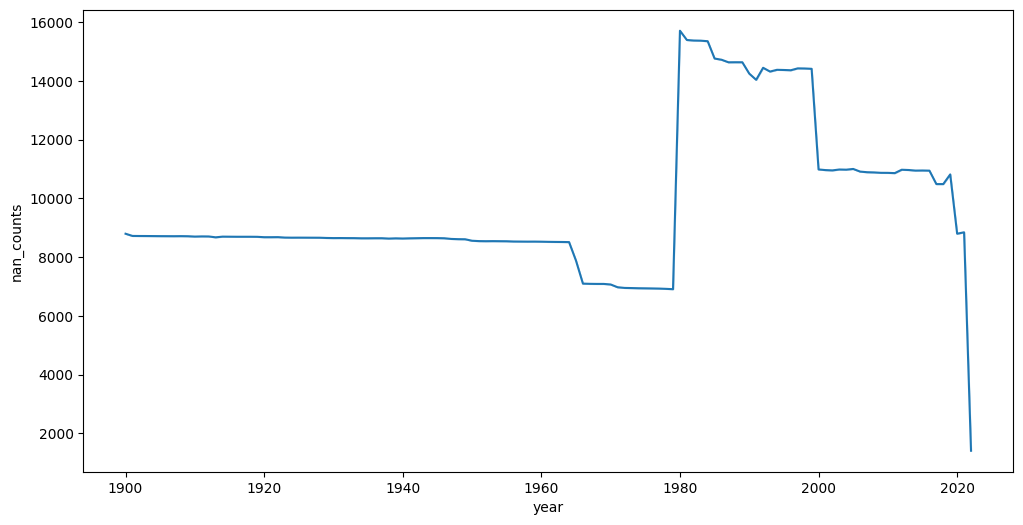

In [42]:
# from the graph, we backtrack to a reasonable time period where null values are at an acceptable range - around 2000
figure = plt.figure(figsize=(12,6))
sb.lineplot(data=nan_count, x = 'year', y = 'nan_counts')

In [43]:
# hence we restrict the years to only 2000 onwards for subsequent analysis
df1 = df1[df1['year'] > 2000]

##### Removing 'country' that are not considered countries

In [44]:
# countries.csv is extracted from online where it contains ISO 3166-1 alpha-3 codes of 193 recognised countries
iso_codes = pd.read_csv('countries.csv')
alpha3 = iso_codes['alpha3'].apply(str.upper).unique()
len(alpha3)

193

In [45]:
# you can tell that there are 6 missing countries in the dataframe
iso_countries = df1[df1['iso_code'].isin(alpha3)]['iso_code'].unique()
len(iso_countries)

187

In [46]:
# make alpha3 into a dataframe (from a numpy array) to check for missing countries
df_alpha3 = pd.DataFrame(alpha3)

# the officially recognised countries not included are: Andorra, Liechtenstein, Marshall Islands, Monacoo, Palau and San Marino
mis_countries = df_alpha3[~df_alpha3.isin(iso_countries)].dropna()
mis_countries

,0
3,AND
99,LIE
108,MHL
114,MCO
132,PLW
148,SMR


In [47]:
# initialise new dataframe to work on plotting the respective columns
df2 = df1[df1['iso_code'].isin(iso_countries)]
df2.head()

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_per_capita,biofuel_elec_per_capita,biofuel_share_elec,biofuel_share_energy,...,solar_cons_change_pct,solar_elec_per_capita,solar_energy_per_capita,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_elec_per_capita,wind_energy_per_capita,wind_share_elec,wind_share_energy
101,Afghanistan,2001,AFG,19688634.0,1.102127e+10,NaN,NaN,0.0,0.0,NaN,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN
102,Afghanistan,2002,AFG,21000258.0,1.880487e+10,NaN,NaN,0.0,0.0,NaN,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN
103,Afghanistan,2003,AFG,22645136.0,2.107434e+10,NaN,NaN,0.0,0.0,NaN,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN
104,Afghanistan,2004,AFG,23553554.0,2.233257e+10,NaN,NaN,0.0,0.0,NaN,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN
105,Afghanistan,2005,AFG,24411196.0,2.539769e+10,NaN,NaN,0.0,0.0,NaN,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN


#### Identified parameters for continent comparison (fossil fuel vs renewables)
1. energy_per_capita - how much each person uses energy
2. fossil_share_energy - % of energy that comes from fossil fuels
3. low_carbon_share_energy - % of energy that comes from renewables and nuclear (include as many renewables in one metric)
4. fossil_cons_change_pct - % change in energy consumption from fossil fuels
5. low_carbon_cons_change_pct - % change in energy consumption from renewables and nuclear
6. fossil_energy_per_capita
7. low_carbon_energy_per_capita

In [53]:
continents = ['Africa', 'Asia', 'Europe', 'North America', 'South America', 'Oceania']
continent_metrics = ['energy_per_capita', 'fossil_share_energy', 'low_carbon_share_energy', 'fossil_cons_change_pct', 'low_carbon_cons_change_pct',
                     'fossil_energy_per_capita', 'low_carbon_energy_per_capita']
continent_data = df1[df1['country'].isin(continents)][['year', 'country'] + continent_metrics]
continent_data.head()

,year,country,energy_per_capita,fossil_share_energy,low_carbon_share_energy,fossil_cons_change_pct,low_carbon_cons_change_pct,fossil_energy_per_capita,low_carbon_energy_per_capita
223,2001,Africa,3954.381,91.676,8.324,3.478,4.003,3625.201,329.180
224,2002,Africa,3921.559,91.385,8.600,1.346,5.734,3583.722,337.266
225,2003,Africa,4010.077,91.948,8.037,5.485,-1.352,3687.167,322.296
226,2004,Africa,4187.799,92.074,7.909,7.235,6.036,3855.892,331.203
227,2005,Africa,4094.096,92.178,7.815,0.374,-0.389,3773.876,319.959


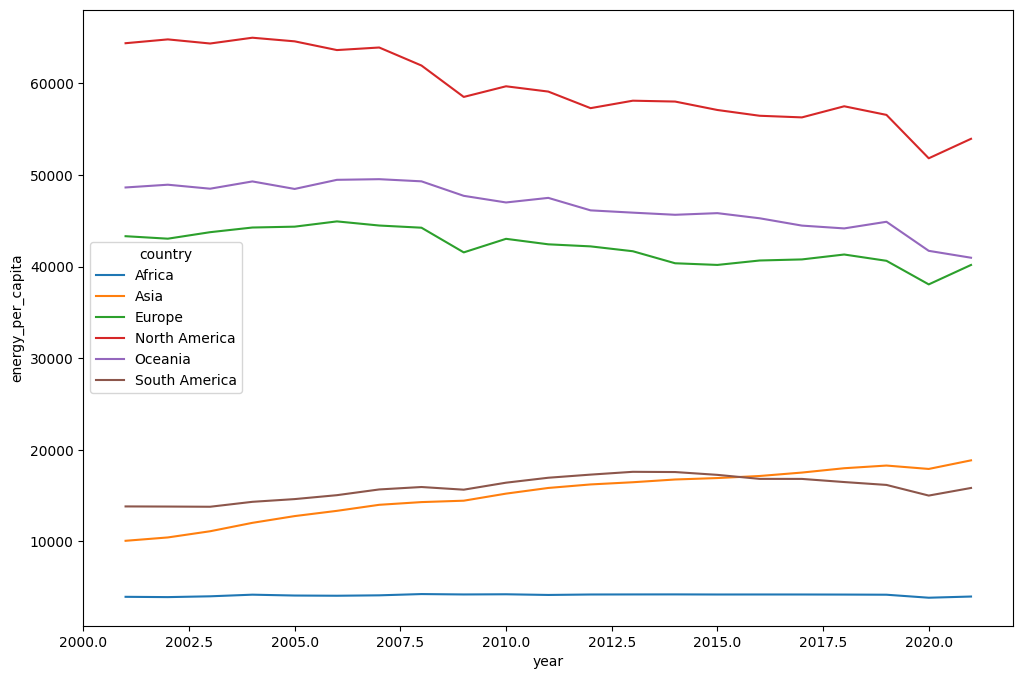

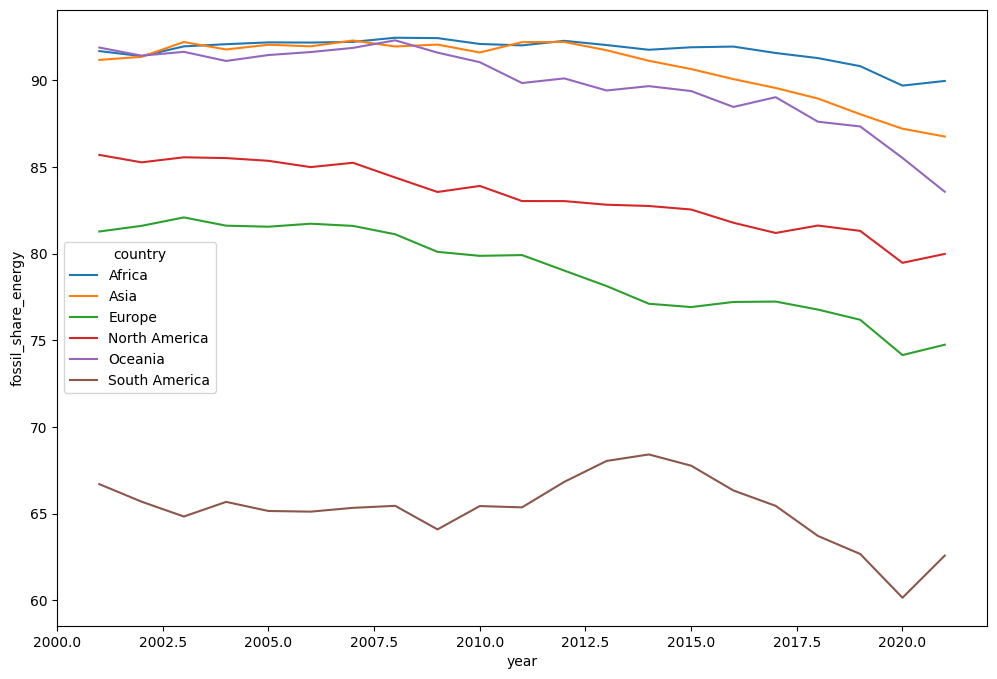

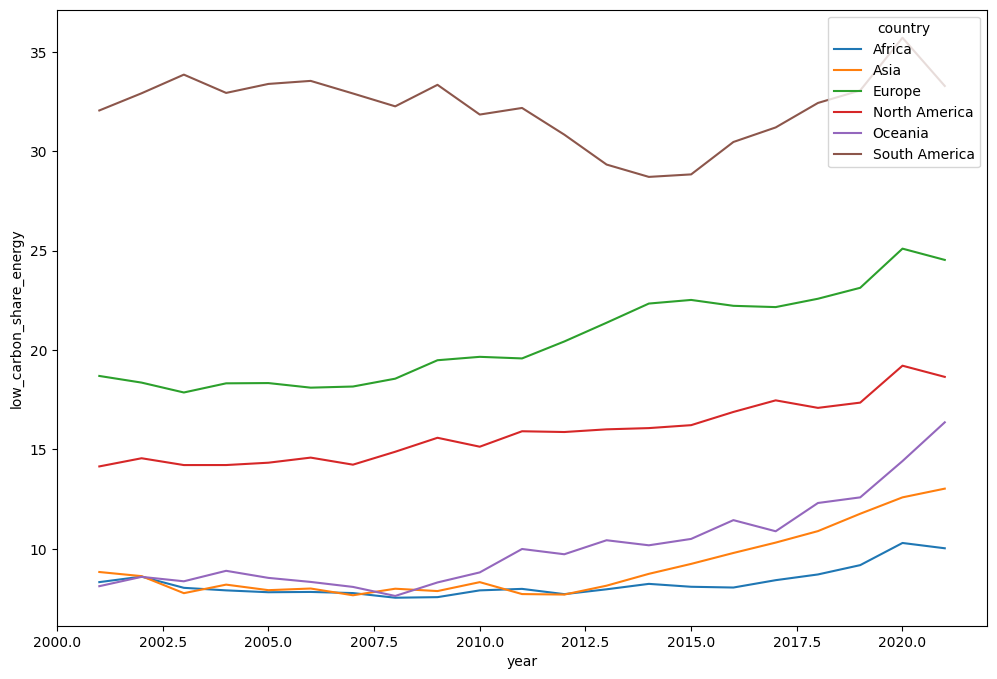

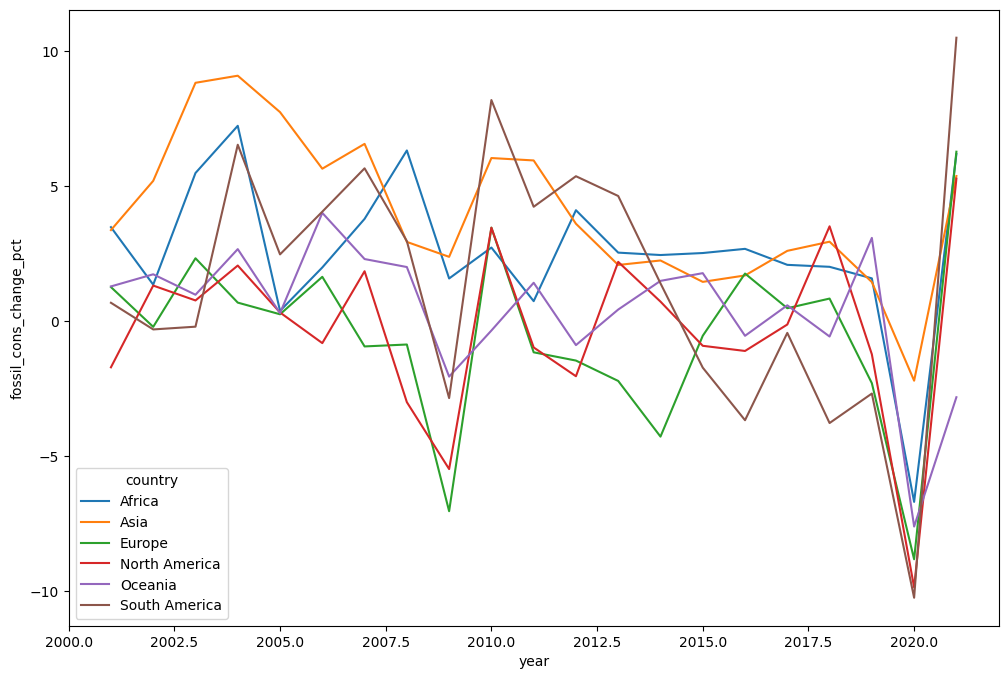

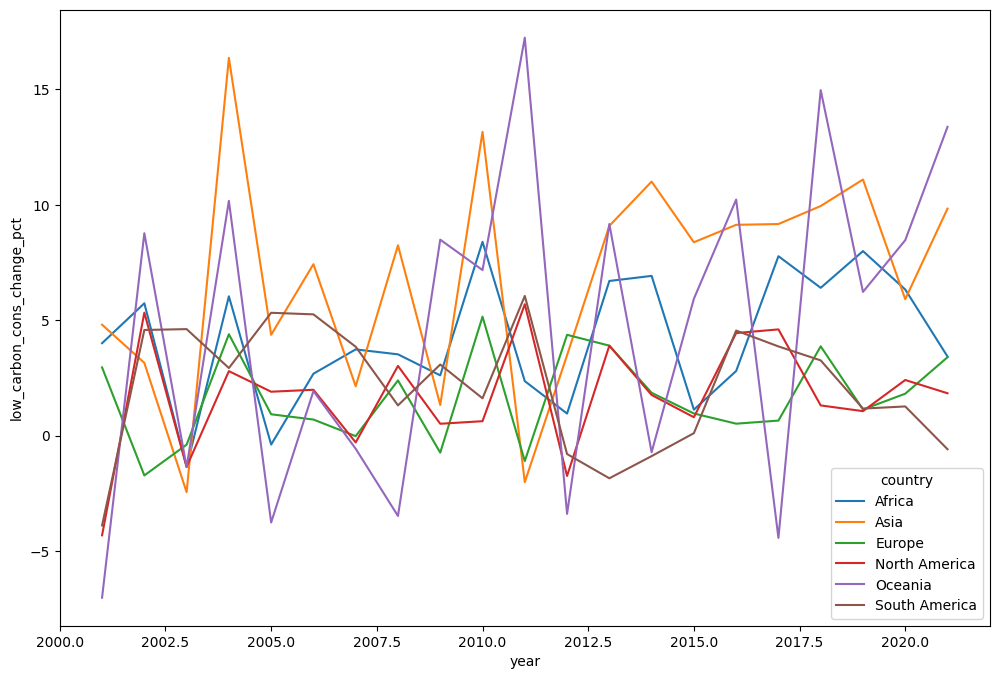

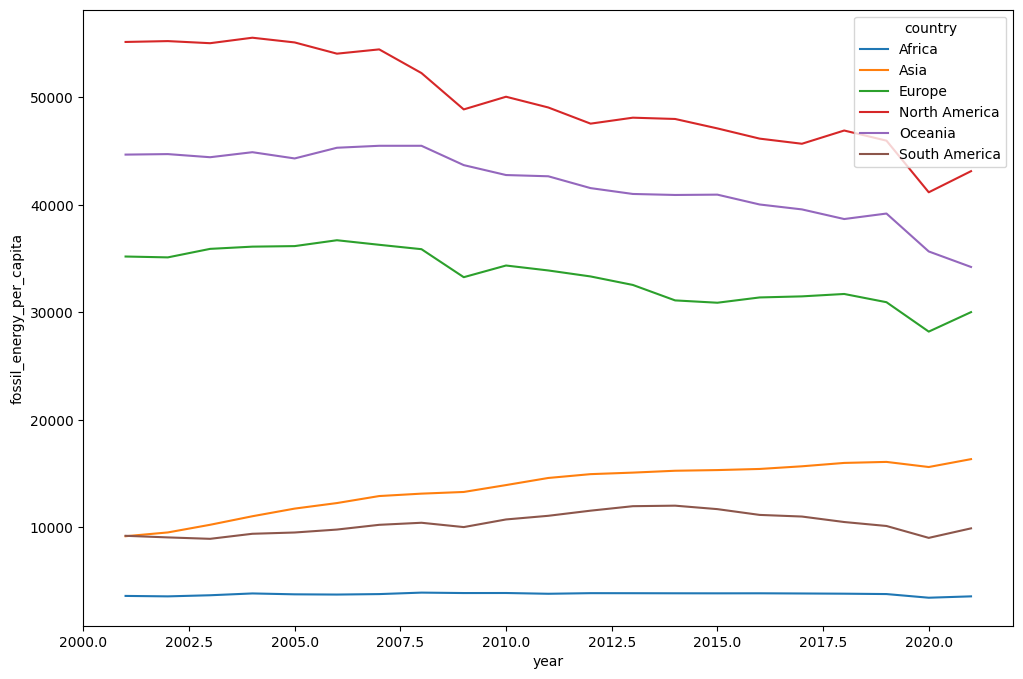

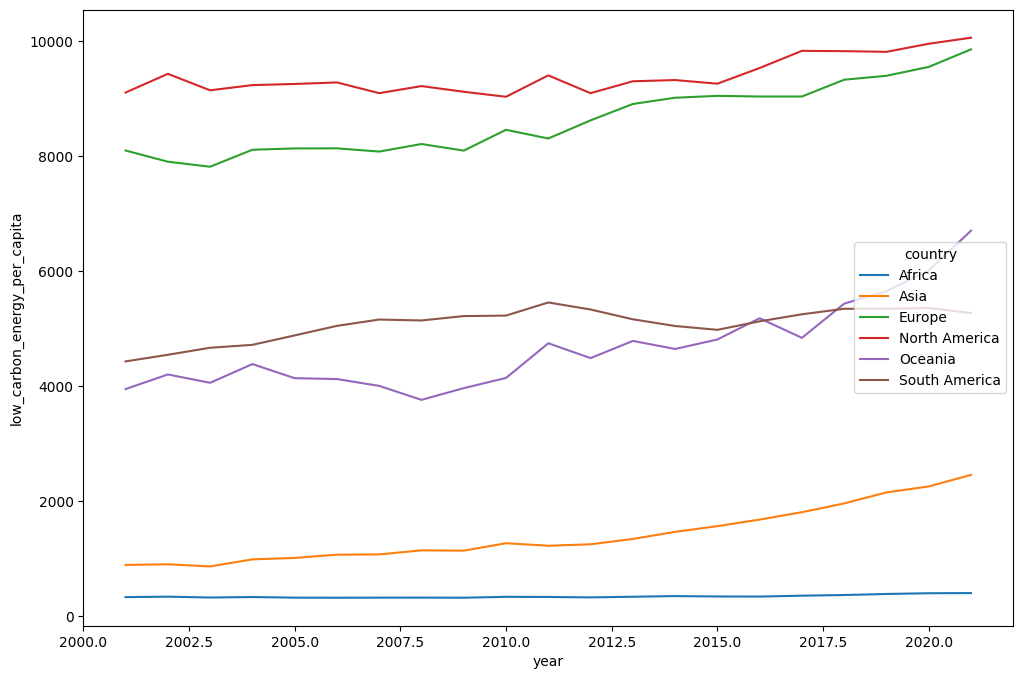

In [54]:
for metric in continent_metrics:
    figure = plt.figure(figsize=(12,8))
    sb.lineplot(data=continent_data, x = 'year', y = metric, hue = 'country')